In [107]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.special
import scipy.stats as stats
import pymc as pm
import seaborn as sns
import pandas as pd
import arviz as az

def credible_interval_from_samples(samples, prob):
    """`samples` can be an nd array. Assume that all of the dimensions
    except for the last index parameters while the last (rightmost)
    dimension indexes the samples."""
    samples_sorted = sort(samples, axis=-1)
    N_samples = samples.shape[-1]
    index = int(N_samples*(1 - prob)/2)
    lower = samples_sorted[..., index]
    upper = samples_sorted[..., -index]
    return lower, upper

Populating the interactive namespace from numpy and matplotlib


# Question 1
A wildlife ecologist contacts you. She works for a large regional park. They have been having problems with wolves attacking small pets in campgrounds and hiking trails. They are interested in exploring the option of relocating the wolves. In order to make a recomendation, they first need to know where the wolves live; that is, they need a precise location of the wolf den. The parks staff has kept records over the past five years of any contact with wolves. Any time a wolf or their tracks are sighted, a position is recorded along with the date. The positions are in kilometers relative to center of the park, with positive `y` pointing north and positive `x` pointing east. You agree to help, and the ecologist sends you a CSV file with the wolf data.


# A
Load the data from the file `wolves.csv` in the data folder into a Pandas dataframe. There are 3 colunns: `x`, `y`, and `date`. Look through the data and locate any rows that have been corrupted, improperly formated, or have incomplete data. Filter out any that you find, and create a new dataframe with the cleaned data.

# B
Plot the positions $x$ vs $y$ as a scatter plot. Label the axes and make it look nice.

# C
Plot a probability density function (using a kernel density estimator) for both $x$ and $y$.

# D
Using the resulting plot from the previous part, make a guess about what distribution you should use as a model of $x_i$ and $y_i$. Your model should depend on the position of the wolf den.

# E
Propose informative priors for any parameters in the model, create prior predictive plots, and describe the reasoning you used to justify your choices.

# F
Use MCMC sampling (use 4 chains each with 1000 samples) to estimate the posterior. Plot the corresponding posterior probability density function for the position of the wolf den (using a KDE). Label the axes and make it look nice.

# G
Filter the data for wolf locations in the winter months (Dec - Feb) and repeat B-F. Do you need to change your priors? Why or why not?

# H
Filter the data for wolf locations in the summer months (June - Aug) and repeat B-F. Do you need to change your priors? Why or why not?

# I
Did you find evidence of a seasonal shift in the location of the wolf den? Explain your answer.

In [43]:
path_to_data = 'https://raw.githubusercontent.com/newby-jay/MATH509-Winter2024-JupyterNotebooks/main/Data/'
data = pd.read_csv(path_to_data + 'wolves.csv', index_col=0)
display(data.describe())

,x,y
count,522.000000,522.000000
mean,42.985824,171.450192
std,69.666388,4379.848575
min,-207.400000,-352.900000
25%,-0.075000,-135.400000
50%,44.500000,-6.600000
75%,91.425000,97.425000
max,256.900000,99999.000000


In [44]:
data.loc[data['y'] == 99999, 'y'] = data.loc[data['y'] != 99999, 'y'].mean()
data['date'] = pd.to_datetime(data['date'], format='mixed', errors='coerce')
data[data['date'] <= '2000-01-01']['date'] = pd.NaT
data.dropna(inplace=True)
display(data.describe())

,x,y,date
count,519.000000,519.000000,519
mean,43.111753,-19.565236,2012-01-01 00:22:11.791907584
min,-207.400000,-352.900000,2010-01-02 00:00:00
25%,0.250000,-135.300000,2011-01-24 00:00:00
50%,44.600000,-6.100000,2011-12-11 00:00:00
75%,91.900000,97.050000,2013-01-06 12:00:00
max,256.900000,277.700000,2013-12-31 00:00:00
std,69.811211,136.714053,NaN


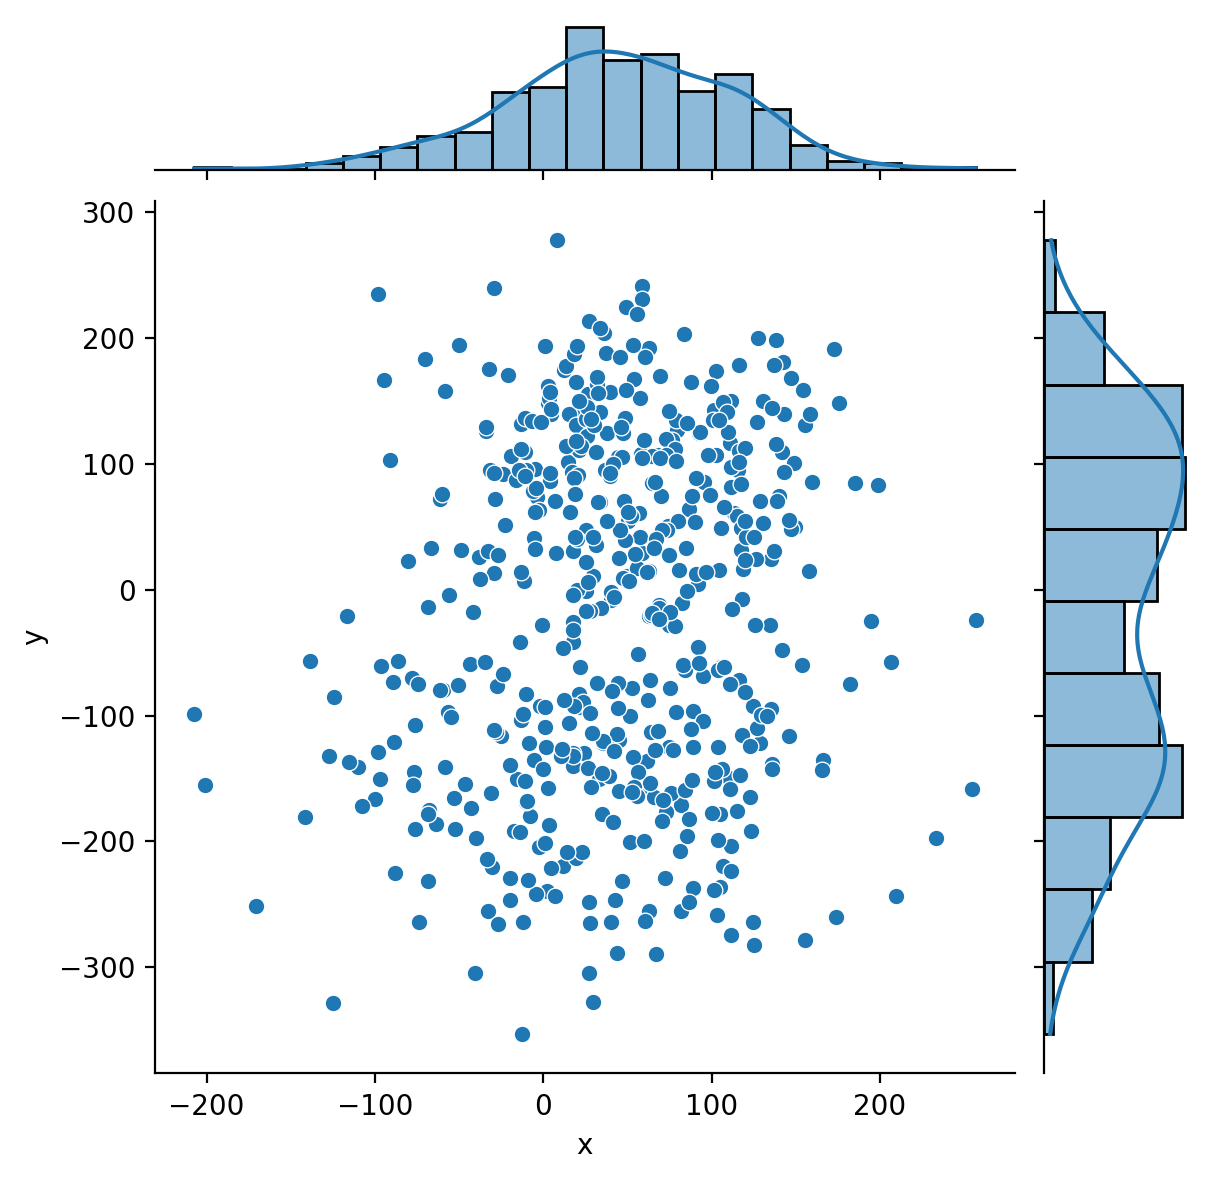

In [80]:
g = sns.jointplot(data=data, x='x', y='y', kind='scatter', marginal_kws=dict(kde=True))

$x \sim \text{Normal}(\mu_x, \sigma)$

$y \sim p\text{Normal}(\mu_{y1}, \sigma) + (1-p)\text{Normal}(\mu_{y2}, \sigma)$

$\mu_x \sim \text{Normal}(10, 100)$

$\mu_{y1} \sim \text{Normal}(100, 100)$

$\mu_{y2} \sim \text{Normal}(-150, 100)$

$\sigma \sim \text{Exponential}(1)$

$p \sim \text{Bernoulli}(0.5)$



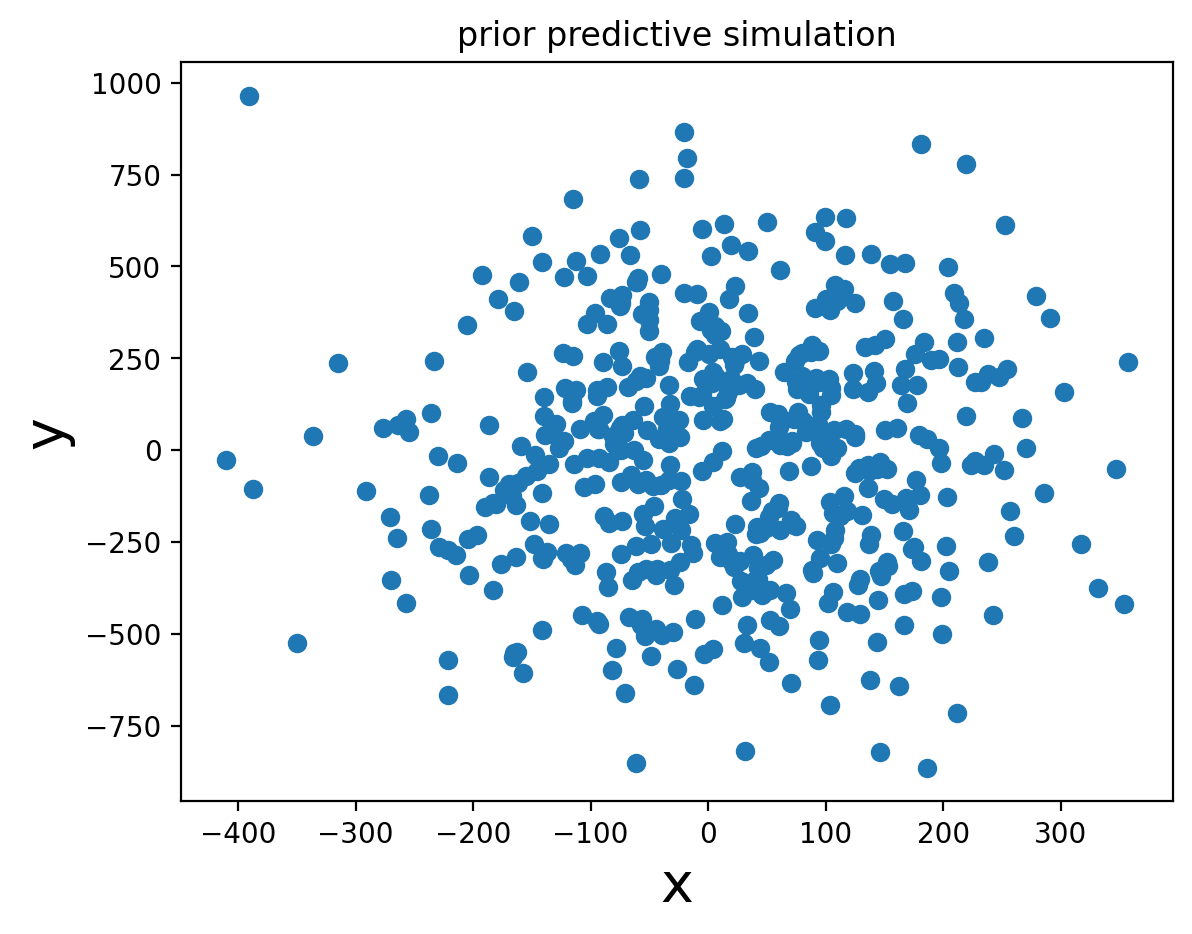

In [125]:
n_samples = 500  # 500 points
sigma_x = stats.expon.rvs(1/120., n_samples)
sigma_y = stats.expon.rvs(1/200., n_samples)
mu_x = stats.norm.rvs(0, 30, n_samples)
mu_y = stats.norm.rvs(0, 30, n_samples)
x = stats.norm.rvs(mu_x, sigma_x, n_samples)
y = stats.norm.rvs(mu_y, sigma_y, n_samples)
plot(x, y, 'o')
# plt.ylim(-100, 400)
title('prior predictive simulation')
xlabel('x', fontsize=20)
ylabel('y', fontsize=20);

In [153]:
_data = data.copy()
with pm.Model() as model:
    sigma_x = pm.Exponential('sigma_x', lam=1/120.)
    sigma_y = pm.Exponential('sigma_y', lam=1/200.)
    mu_x = pm.Normal('mu_x', mu=0., sigma=30.)
    mu_y = pm.Normal('mu_y', mu=0., sigma=30.)
    x = pm.Normal('x', mu=mu_x, sigma=sigma_x, observed=_data['x'])
    y = pm.Normal('y', mu=mu_y, sigma=sigma_y, observed=_data['y'])
    ## MCMC
    posterior_1 = pm.sample(1000, tune=1000, chains=4)
posterior_df_1 = posterior_1.posterior.to_dataframe()

Output()

Output()

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_x,42.665,3.125,37.079,48.800,0.038,0.027,6708.0,3012.0,1.0
mu_y,-18.772,5.687,-29.844,-8.749,0.069,0.052,6795.0,3387.0,1.0
sigma_x,69.942,2.181,65.968,74.098,0.026,0.019,7111.0,3024.0,1.0
sigma_y,136.896,4.301,129.026,145.052,0.050,0.035,7433.0,3296.0,1.0


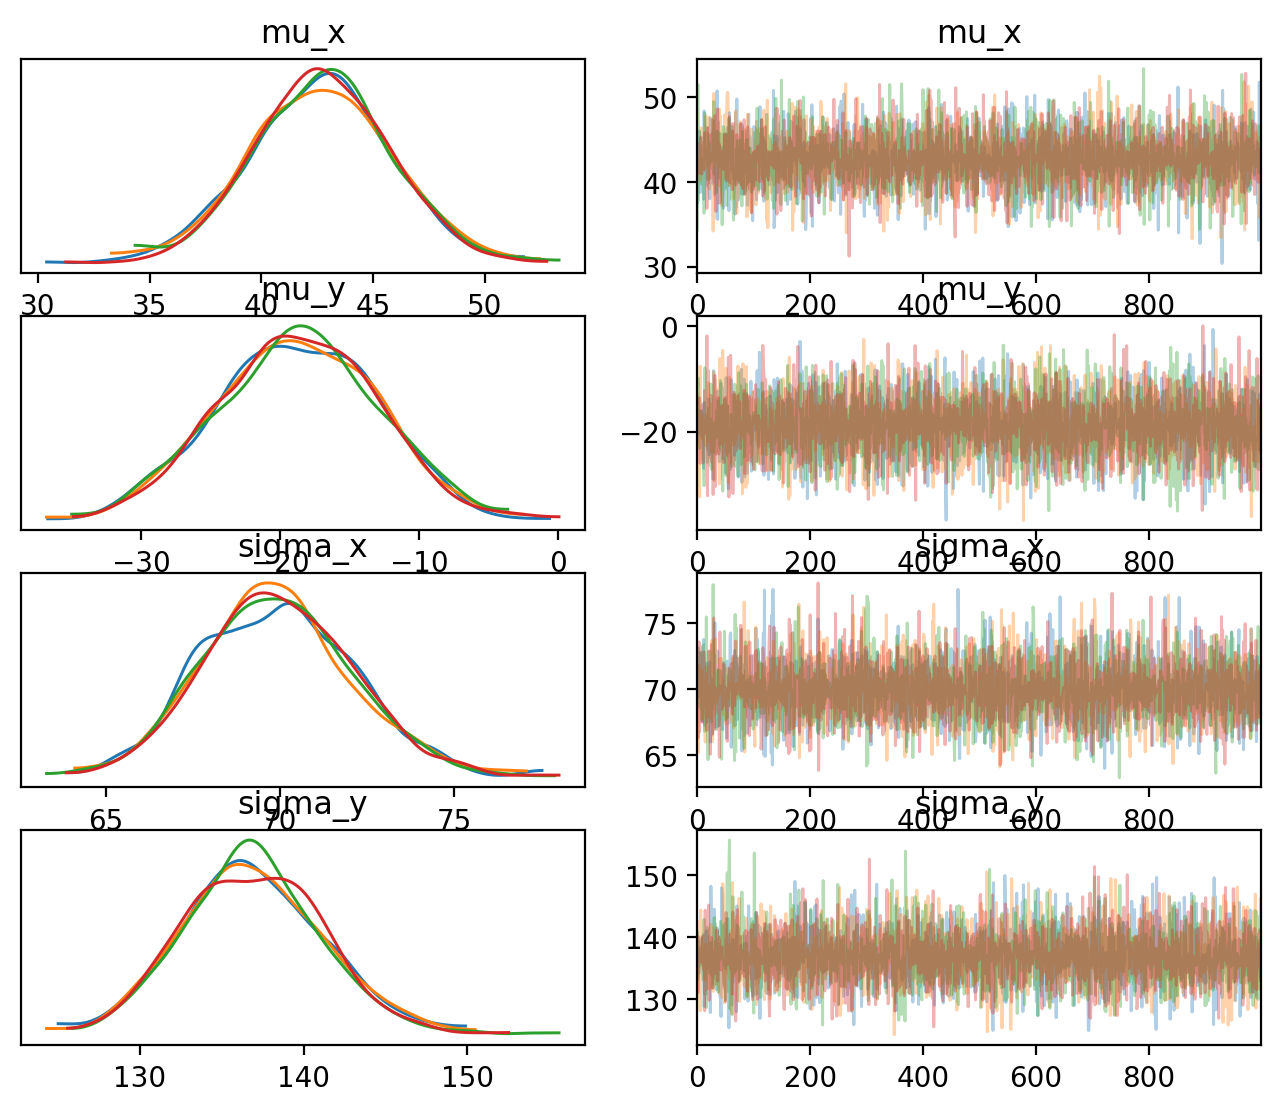

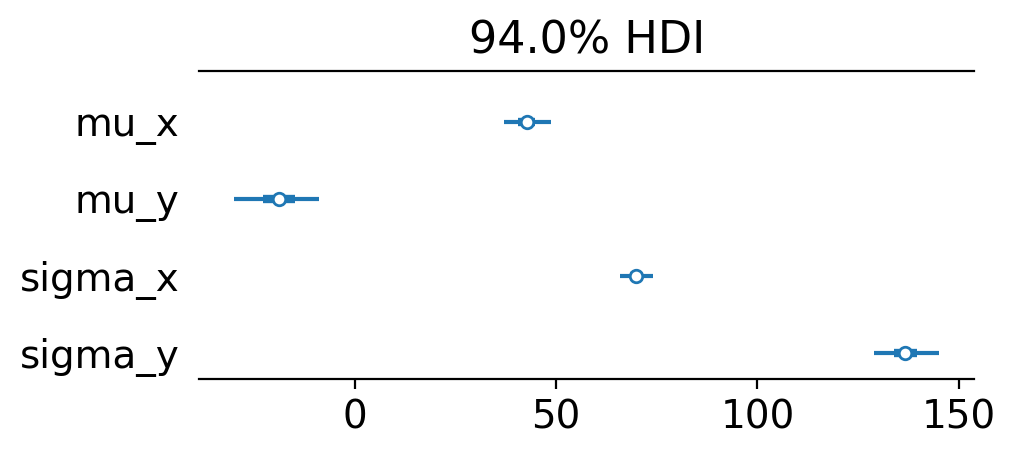

In [154]:
varnames = ['mu_x', 'mu_y', 'sigma_x', 'sigma_y']
display(pm.summary(posterior_1, var_names=varnames))
az.plot_trace(posterior_1, varnames, compact=False, figsize=(8, 1.6*len(varnames)))
az.plot_forest(posterior_1, var_names=varnames, combined=True, figsize=[5, 2]);

<Axes: xlabel='mu_x', ylabel='mu_y'>

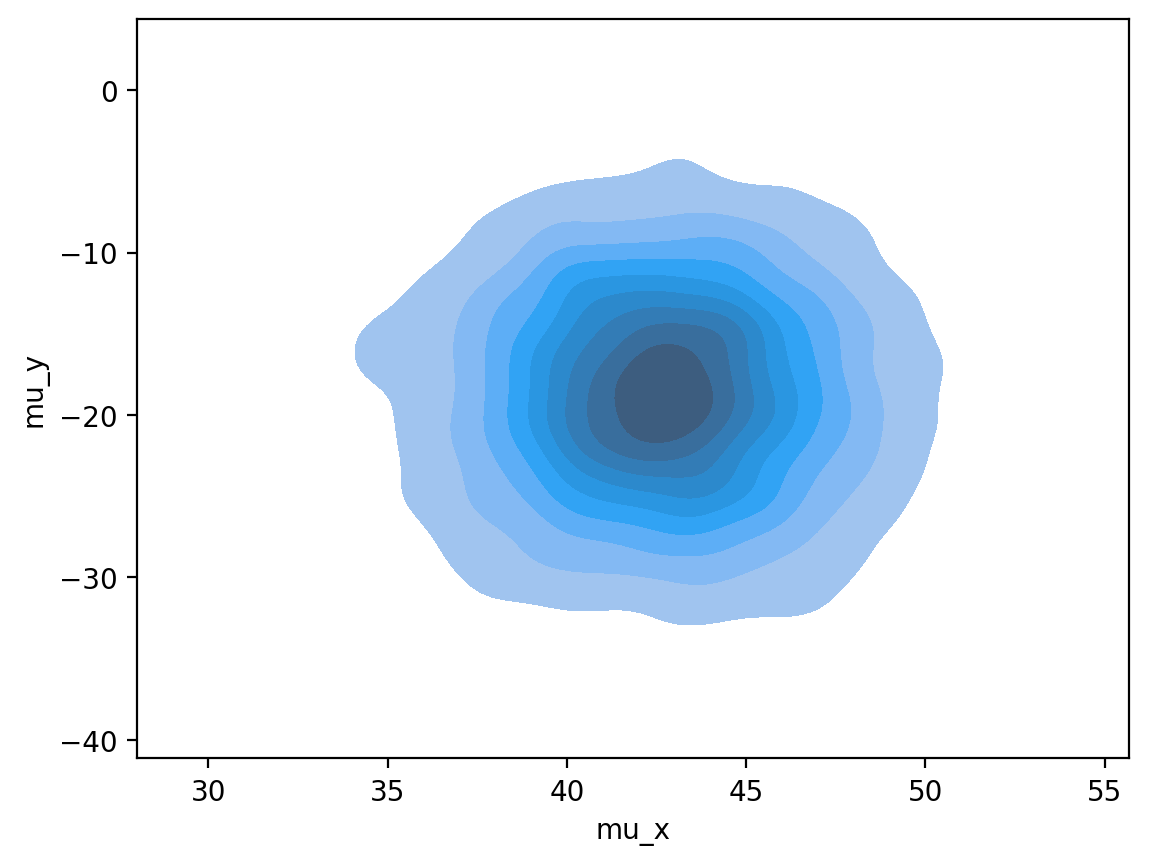

In [155]:
sns.kdeplot(posterior_df_1, x='mu_x', y='mu_y', fill=True)a

In [156]:
_data = data.where(data['date'].dt.month.isin([12, 1, 2])).dropna()
with pm.Model() as model:
    sigma_x = pm.Exponential('sigma_x', lam=1/120.)
    sigma_y = pm.Exponential('sigma_y', lam=1/200.)
    mu_x = pm.Normal('mu_x', mu=0., sigma=30.)
    mu_y = pm.Normal('mu_y', mu=0., sigma=30.)
    x = pm.Normal('x', mu=mu_x, sigma=sigma_x, observed=_data['x'])
    y = pm.Normal('y', mu=mu_y, sigma=sigma_y, observed=_data['y'])
    ## MCMC
    posterior_2 = pm.sample(1000, tune=1000, chains=4)
posterior_df_2 = posterior_2.posterior.to_dataframe()

Output()

Output()

Output()

Output()

<Axes: xlabel='mu_x', ylabel='mu_y'>

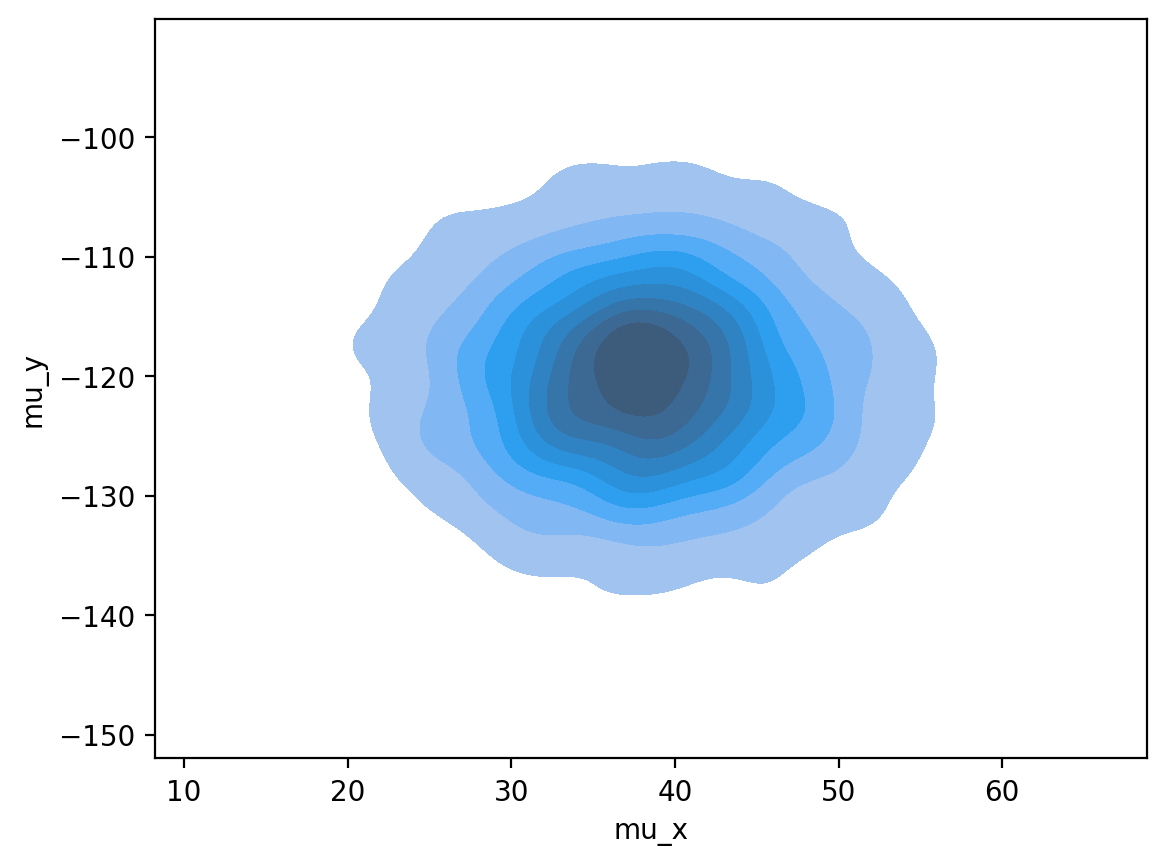

In [158]:
_data = data.where(data['date'].dt.month.isin([6, 7, 8])).dropna()
with pm.Model() as model:
    sigma_x = pm.Exponential('sigma_x', lam=1/120.)
    sigma_y = pm.Exponential('sigma_y', lam=1/200.)
    mu_x = pm.Normal('mu_x', mu=0., sigma=30.)
    mu_y = pm.Normal('mu_y', mu=0., sigma=30.)
    x = pm.Normal('x', mu=mu_x, sigma=sigma_x, observed=_data['x'])
    y = pm.Normal('y', mu=mu_y, sigma=sigma_y, observed=_data['y'])
    ## MCMC
    posterior_3 = pm.sample(1000, tune=1000, chains=4)
posterior_df_3 = posterior_3.posterior.to_dataframe()

Output()

Output()

Output()

Output()

<Axes: xlabel='mu_x', ylabel='mu_y'>

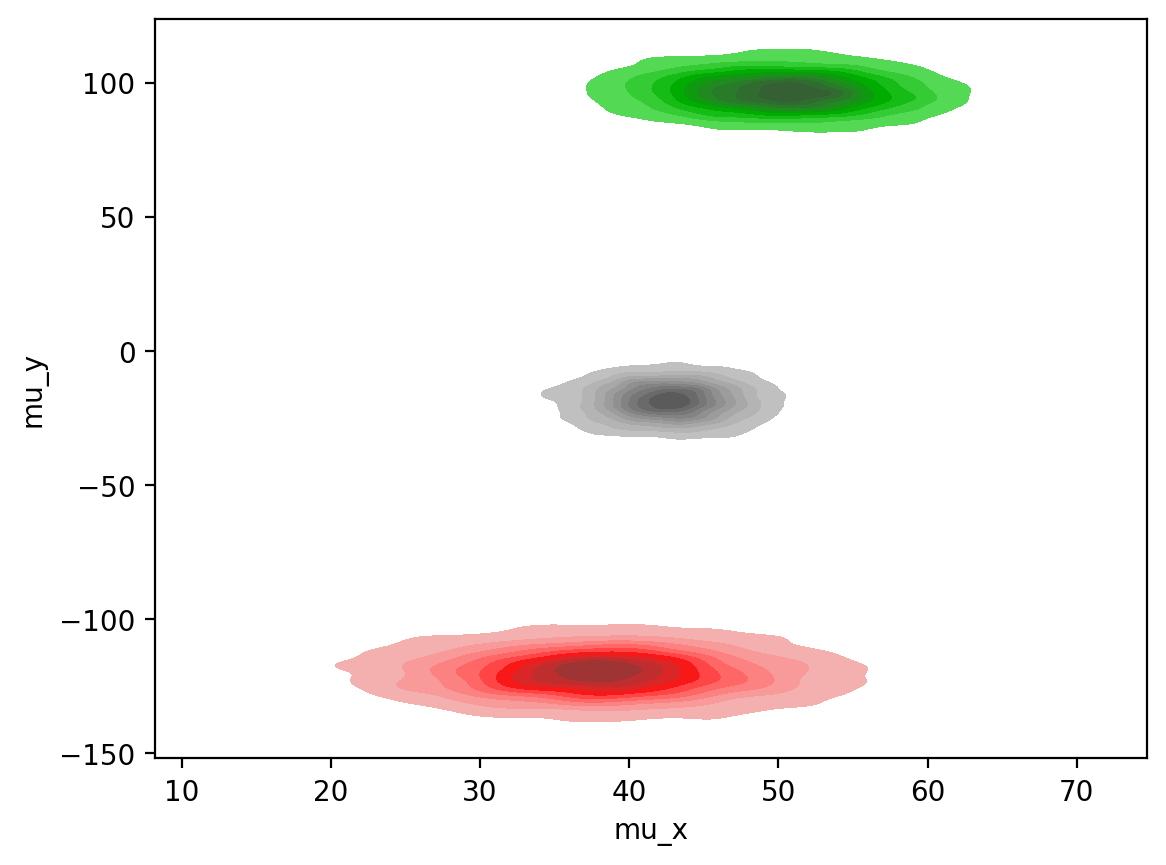

In [168]:
sns.kdeplot(posterior_df_1, x='mu_x', y='mu_y', fill=True, color='grey')
sns.kdeplot(posterior_df_2, x='mu_x', y='mu_y', fill=True, color='red')
sns.kdeplot(posterior_df_3, x='mu_x', y='mu_y', fill=True, color='green')